In [1]:
import gc
import torch
import torchaudio
import librosa
import keras
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import warnings

tqdm.pandas()
# suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
RATE_HZ = 16000 # resampling rate in Hz
MAX_LENGTH = 128000 # maximum audio interval length to consider (= RATE_HZ * SECONDS)
CSV_FILE_PATH: str = "bio_metadata.csv"
NATIVE_FILE_PATH: str = "native_bio_metadata.csv"
ALL_SPEAKERS_PATH: str = "speakers_all.csv"
NON_NATIVE_FILE_PATH: str = "non_native_bio_metadata.csv"
COL_SIZE: int = 30
SILENCE_THRESHOLD: float = .01
RATE: int = 2400
N_MFCC: int = 13

In [3]:
# extract acoustic features from audio files function
def extract_mfcc_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=N_MFCC)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    return mfccs_processed

In [4]:
# get wav from file function
def get_wav(file_name):
    try:
        audio, sample_rate = librosa.load(f'./data/audio/{file_name}.wav')
        return librosa.core.resample(y=audio, orig_sr=sample_rate, target_sr=RATE, scale=True)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None

# convert wave to mfcc function
def wave_to_mfcc(audio, sample_rate):
    try:
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=N_MFCC)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error encountered while parsing audio")
        return None
    return mfccs_processed

# normalize mfcc function
def normalize_mfcc(mfcc):
    mms = MinMaxScaler()
    return mms.fit_transform(np.abs(mfcc))

# to categorical function
def to_categorical(y):
    lang_dict = {}
    for index, language in enumerate(set(y)):
        lang_dict[language] = index
    y = list(map(lambda x: lang_dict[x],y))
    return keras.utils.to_categorical(y, len(lang_dict)), lang_dict


In [5]:
# load the native_bio_metadata.csv
native_bio_metadata = pd.read_csv(NATIVE_FILE_PATH)
native_bio_metadata.head()

,href,language_num,sex,birth_place,native_language,other_languages,age_sex,age_of_english_onset,english_learning_method,english_residence,length_of_english_residence,age
0,http://accent.gmu.edu/browse_language.php?func...,mandarin1,female,"['shanxi,', 'china']",mandarin\n(cmn),['none'],"['26,', 'female', '']",13.0,academic,usa,2.0,26.0
1,http://accent.gmu.edu/browse_language.php?func...,mandarin2,female,"['nanjing,', 'china']",mandarin\n(cmn),"['japanese', '']","['38,', 'female', '']",14.0,academic,usa,0.8,38.0
2,http://accent.gmu.edu/browse_language.php?func...,mandarin3,male,"['jilin,', 'china']",mandarin\n(cmn),"['italian', 'german', 'french', '']","['43,', 'male', '']",10.0,academic,usa,14.0,43.0
3,http://accent.gmu.edu/browse_language.php?func...,mandarin4,female,"['shanghai,', 'china']",mandarin\n(cmn),"['japanese', '']","['24,', 'female', '']",6.0,academic,usa,1.0,24.0
4,http://accent.gmu.edu/browse_language.php?func...,mandarin5,female,"['beijing,', 'china']",mandarin\n(cmn),['none'],"['31,', 'female', '']",12.0,academic,usa,2.0,31.0


In [6]:
# drop href, age_sex, age_of_english_onset, other_languages, birthplace
native_bio_metadata.drop(columns=['href', 'age', 'age_of_english_onset', 'other_languages', 'birth_place', 'age_sex', 'length_of_english_residence', 'english_learning_method'], inplace=True)
native_bio_metadata.head()

,language_num,sex,native_language,english_residence
0,mandarin1,female,mandarin\n(cmn),usa
1,mandarin2,female,mandarin\n(cmn),usa
2,mandarin3,male,mandarin\n(cmn),usa
3,mandarin4,female,mandarin\n(cmn),usa
4,mandarin5,female,mandarin\n(cmn),usa


In [7]:
# describe the native_bio_metadata
native_bio_metadata.describe()

,language_num,sex,native_language,english_residence
count,1224,1224,1224,1224
unique,1169,2,27,3
top,english578,female,english\n(eng),usa
freq,3,635,604,1031


In [8]:
# remove \n and select first one in native_bio_metadata['english_residence']
native_bio_metadata['english_residence'] = native_bio_metadata['english_residence'].apply(lambda x: x.split('\n')[0])
native_bio_metadata.sample(10)

,language_num,sex,native_language,english_residence
319,english45,male,english\n(eng),usa
862,german30,female,german\n(deu),usa
1206,french7,male,french\n(fra),canada
689,english553,male,english\n(eng),usa
1171,english238,female,english\n(eng),canada
280,arabic189,female,arabic\n(ars),usa
984,korean97,female,korean\n(kor),usa
456,english234,male,english\n(eng),usa
812,french37,male,french\n(fra),usa
816,french49,male,french\n(fra),usa


In [9]:
# value counts
native_bio_metadata['english_residence'].value_counts()

english_residence
usa       1031
uk         115
canada      78
Name: count, dtype: int64

In [10]:
native_bio_metadata.shape

(1224, 4)

In [11]:
# to categorical function
def to_categorical(y):
    lang_dict = {}
    for index, language in enumerate(set(y)):
        lang_dict[language] = index
    y = list(map(lambda x: lang_dict[x],y))
    return keras.utils.to_categorical(y, len(lang_dict)), lang_dict

In [12]:
# add a new column 'file' with the full path of the audio file, the audio files are location in './data/native_combined/'
native_bio_metadata.loc[:, 'file'] = native_bio_metadata['language_num'].apply(lambda x: f"data/audio/{x}.wav")
native_bio_metadata.head()

,language_num,sex,native_language,english_residence,file
0,mandarin1,female,mandarin\n(cmn),usa,data/audio/mandarin1.wav
1,mandarin2,female,mandarin\n(cmn),usa,data/audio/mandarin2.wav
2,mandarin3,male,mandarin\n(cmn),usa,data/audio/mandarin3.wav
3,mandarin4,female,mandarin\n(cmn),usa,data/audio/mandarin4.wav
4,mandarin5,female,mandarin\n(cmn),usa,data/audio/mandarin5.wav


In [13]:
native_bio_metadata['english_residence'].value_counts()

english_residence
usa       1031
uk         115
canada      78
Name: count, dtype: int64

In [14]:
def get_transform_audio(file):
    audio,rate = torchaudio.load(str(file))
    transform = torchaudio.transforms.Resample(rate,RATE_HZ)
    audio = transform(audio).squeeze(0).numpy()
    audio = audio[:MAX_LENGTH] # truncate to first part of audio to save RAM
    return audio

In [15]:
native_bio_metadata['audio'] = native_bio_metadata['file'].progress_apply(get_transform_audio)

100%|██████████| 1224/1224 [01:08<00:00, 17.88it/s]


In [16]:
native_bio_metadata.sample(5)

,language_num,sex,native_language,english_residence,file,audio
497,english293,female,english\n(eng),usa,data/audio/english293.wav,"[-1.4186824e-06, 4.046085e-06, 8.578898e-06, -..."
241,arabic150,female,arabic\n(ars),usa,data/audio/arabic150.wav,"[-3.062122e-05, -1.8767698e-05, -1.9263782e-05..."
1027,portuguese64,female,portuguese\n(por),usa,data/audio/portuguese64.wav,"[2.6565354e-05, 5.313162e-06, 6.316313e-05, 3...."
1205,english647,male,english\n(eng),canada,data/audio/english647.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1157,english64,female,english\n(eng),canada,data/audio/english64.wav,"[-1.7002e-05, 3.5281541e-06, -6.498487e-06, 9...."


In [17]:
# create an upsampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

ros = RandomOverSampler(random_state=42)
X = native_bio_metadata.drop(columns=['native_language', 'sex'])
y = native_bio_metadata['english_residence']
X_resampled, y_resampled = ros.fit_resample(X, y)


rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [18]:
X_resampled['english_residence'].value_counts()

english_residence
canada    78
uk        78
usa       78
Name: count, dtype: int64

In [19]:
X = native_bio_metadata['audio'].values
y = native_bio_metadata['english_residence'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((979,), (245,), (979,), (245,))

In [20]:
# create a counter for train and test labels
train_counter = Counter(y_train)
test_counter = Counter(y_test)

print(f"Train Count: {train_counter}")
print(f"Test Count: {test_counter}")

Train Count: Counter({'usa': 825, 'uk': 92, 'canada': 62})
Test Count: Counter({'usa': 206, 'uk': 23, 'canada': 16})


In [21]:
y_train_cat, _ = to_categorical(y_train)
y_test_cat, lang_dict = to_categorical(y_test)

In [22]:
lang_dict

{'uk': 0, 'canada': 1, 'usa': 2}

In [23]:
X_train[0]

array([ 1.1469562e-06,  3.4527941e-06, -5.3884582e-06, ...,
        4.1928481e-02,  1.3955630e-02, -7.4105812e-03], dtype=float32)

In [24]:
# create pytorch model to train the data on
class AcousticDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Concatenate the features within each sample
        features = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.y[idx], dtype=torch.long)  # self.y[idx] is the label index
        return features, label

In [25]:
train_dataset = AcousticDataset(X_train, y_train_cat)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [26]:
# create the data loaders
val_dataset = AcousticDataset(X_test, y_test_cat)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [27]:
# Get the dimension of the input feature
input_dim = train_dataset[0][0].shape[0]
input_dim

128000

In [28]:
# Get the dimension of the input feature
# input_dim = train_dataset[0][0].shape[0] + train_dataset[0][1].shape[0]

# input_dim = 42

model = nn.Sequential(
    nn.Linear(input_dim, 128),  # Change this to match input size 8, 16, 32, 64, 128, 256, 512, 1024, 2048
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, len(lang_dict))
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [29]:
# Train the model
n_epochs = 50
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        # print(target)
        target_indices = torch.argmax(target, dim=1)
        # data = data.unsqueeze(1)
        # Assuming data has shape (batch_size, 42)
        output = model(data)
        loss = criterion(output, target_indices)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    for data, target in val_loader:
        target_indices = torch.argmax(target, dim=1)
        # data = data.unsqueeze(1)
        output = model(data)
        loss = criterion(output, target_indices)
        val_loss += loss.item() * data.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")


Epoch 1/50 Train Loss: 0.7782 Val Loss: 0.5606
Epoch 2/50 Train Loss: 0.5478 Val Loss: 0.5483
Epoch 3/50 Train Loss: 0.5420 Val Loss: 0.5464
Epoch 4/50 Train Loss: 0.5400 Val Loss: 0.5466
Epoch 5/50 Train Loss: 0.5393 Val Loss: 0.5464
Epoch 6/50 Train Loss: 0.5374 Val Loss: 0.5466
Epoch 7/50 Train Loss: 0.5360 Val Loss: 0.5477
Epoch 8/50 Train Loss: 0.5317 Val Loss: 0.5477
Epoch 9/50 Train Loss: 0.5249 Val Loss: 0.5492
Epoch 10/50 Train Loss: 0.5113 Val Loss: 0.5532
Epoch 11/50 Train Loss: 0.4772 Val Loss: 0.5648
Epoch 12/50 Train Loss: 0.3928 Val Loss: 0.6125
Epoch 13/50 Train Loss: 0.2796 Val Loss: 0.7366
Epoch 14/50 Train Loss: 0.2302 Val Loss: 0.8504
Epoch 15/50 Train Loss: 0.2100 Val Loss: 0.9048
Epoch 16/50 Train Loss: 0.2033 Val Loss: 0.9476
Epoch 17/50 Train Loss: 0.2147 Val Loss: 0.9236
Epoch 18/50 Train Loss: 0.2015 Val Loss: 0.8630
Epoch 19/50 Train Loss: 0.1982 Val Loss: 0.9163
Epoch 20/50 Train Loss: 0.1927 Val Loss: 0.9413
Epoch 21/50 Train Loss: 0.1915 Val Loss: 0.9906
E

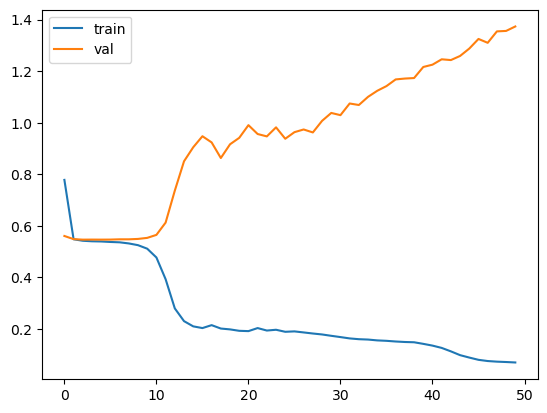

In [30]:
# plot the training and validation loss
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()


In [31]:
# get the accuracy of the model
correct = 0
total = 0
with torch.no_grad():
    for data, target in val_loader:
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target_indices).sum().item()
        
print(f"Accuracy: {correct / total:.2f}")

Accuracy: 0.80
